# 👀 Multilayer perceptron (MLP)

In this notebook, we'll walk through the steps required to train your own multilayer perceptron on the CIFAR dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2

from notebooks.utils import display

## 0. Parameters

In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Let's use CUDA ({gpu_name})")
else:
    device = torch.device('cpu')

Let's use CUDA (NVIDIA RTX 6000 Ada Generation)


## 1. Prepare the Data

In [4]:
transforms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_set = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms)
test_set = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

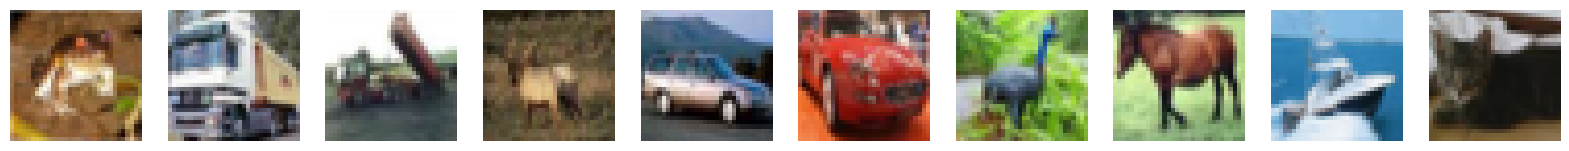

[6 9 9 4 1 1 2 7 8 3]


In [6]:
x_train = np.array([train_set[i][0] for i in range(10)])
y_train = np.array([train_set[i][1] for i in range(10)])
display(x_train)
print(y_train)

## 2. Build the model

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 200),
            nn.ReLU(),
            nn.Linear(200, 150),
            nn.ReLU(),
            nn.Linear(150, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

## 3. Train the model

In [8]:
model = MLP()
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.0005)

In [9]:
for _ in range(EPOCHS):
    model.train()
    progress = tqdm(train_loader)
    for batch in progress:
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        log_y_pred = model(X)
        loss = F.nll_loss(log_y_pred, y)
        acc = (log_y_pred.argmax(dim=1) == y).float().mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        progress.set_description(f'loss: {loss.item():.4f}, accuracy: {acc.item():.4f}')

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

## 4. Evaluation

In [10]:
avg_loss = 0.0
avg_acc = 0.0
count = 0
preds = []
model.eval()
for X, y in tqdm(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        log_y_pred = model(X)
        loss = F.nll_loss(log_y_pred, y)
        acc = (log_y_pred.argmax(dim=-1) == y).float().mean()

    avg_loss += loss.item() * X.size(0)
    avg_acc += acc.item() * X.size(0)
    count += X.size(0)
    preds.append(log_y_pred.detach().cpu().numpy())

avg_loss /= count
avg_acc /= count
preds = np.concatenate(preds, axis=0)

print(f'[Test] loss: {avg_loss:.4f}, accuracy: {avg_acc:.4f}')

  0%|          | 0/313 [00:00<?, ?it/s]

[Test] loss: 1.4203, accuracy: 0.4984


In [11]:
CLASSES = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
])

preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[test_set.targets]

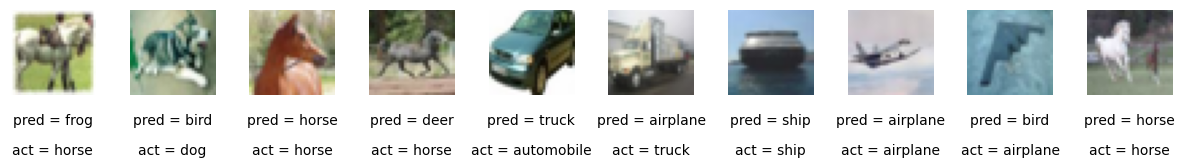

In [12]:
n_to_show = 10
indices = np.random.choice(range(len(test_set)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = test_set.data[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)